In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/carlmcbrideellis/llm-mistral-7b-instruct-texts")

Skipping, found downloaded files in ".\llm-mistral-7b-instruct-texts" (use force=True to force download)


In [2]:

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import seaborn as sns


In [3]:

# Load data
essays = pd.read_csv('train_essays.csv')


In [4]:

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and stem the words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)


In [5]:

# Preprocess data
essays['cleaned_text'] = essays['text'].apply(preprocess_text)


# Print the number of preprocessed texts
print(f"Number of preprocessed texts: {len(essays['cleaned_text'])}")


Number of preprocessed texts: 1378


In [6]:

# Load/Process more data
mo_essays = 'C:\\Users\\jpark\\llm-mistral-7b-instruct-texts\\Mistral7B_CME_v7.csv'
mo_essays = pd.read_csv(mo_essays)


mo_essays['cleaned_text'] = mo_essays['text'].apply(preprocess_text)


# Print the number of preprocessed texts
print(f"Number of preprocessed texts: {len(essays['cleaned_text'])}")


Number of preprocessed texts: 1378


In [7]:

# Format
essays = essays[['prompt_id', 'cleaned_text', 'generated']]
mo_essays = mo_essays[['prompt_id', 'cleaned_text', 'generated']]


In [8]:

# combine essays and mo_essays
combined_df = pd.concat([essays, mo_essays], ignore_index=True)


# Resetting index after concatenation
combined_df.reset_index(drop=True, inplace=True)

# Print the combined DataFrame
print(combined_df)


      prompt_id                                       cleaned_text  generated
0             0  car car around sinc becam famou henri ford cre...          0
1             0  transport larg necess countri worldwid doubt c...          0
2             0  america love affair vehicl seem cool say elisa...          0
3             0  often ride car drive one motor vehicl work sto...          0
4             0  car wonder thing perhap one world greatest adv...          0
...         ...                                                ...        ...
6273         12  elector colleg one discuss polit institut unit...          1
6274         12  dear sen name write express thought topic whet...          1
6275         12  elector colleg system use unit state determin ...          1
6276         12  strong elector system vital function democraci...          1
6277         12  elector colleg system use unit state elect pre...          1

[6278 rows x 3 columns]


In [9]:

# Split constants and variable
X = combined_df[['prompt_id', 'cleaned_text']]
y = combined_df['generated']


In [10]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_vec = vectorizer.transform(X_test['cleaned_text'])

# Create an instance of classifier and train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vec, y_train)

# Make predictions
predictions = model.predict(X_test_vec)


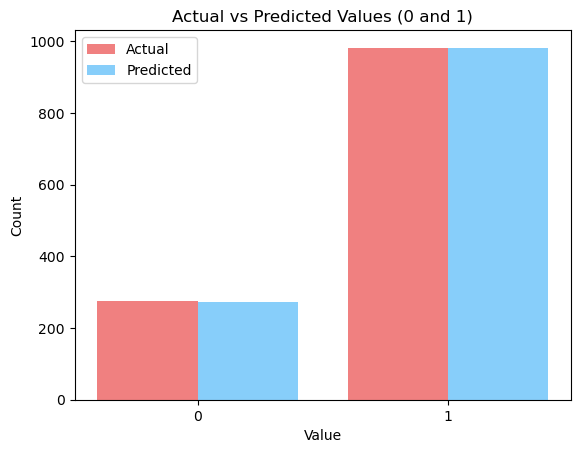

In [11]:

# Add predictions to X_test
X_test['predicted'] = predictions
X_test['actual'] = y_test

# Compare actual and predicted values
comparison = X_test[['actual', 'predicted']]

# Predition count
actual_counts = X_test['actual'].value_counts().sort_index()
predicted_counts = X_test['predicted'].value_counts().sort_index()

# Bar chart for actual values
plt.bar(actual_counts.index - 0.2, actual_counts, width=0.4, label='Actual', color='lightcoral')

# Bar chart for predicted values
plt.bar(predicted_counts.index + 0.2, predicted_counts, width=0.4, label='Predicted', color='lightskyblue')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Actual vs Predicted Values')
plt.xticks([0, 1])

# Adding legend
plt.legend()

# Show the bar chart
plt.show()

In [12]:

# Get class probabilities
probabilities = model.predict_proba(X_test_vec)

# Add probabilities to X_test
X_test['prob_0'] = probabilities[:, 0]
X_test['prob_1'] = probabilities[:, 1]

# Threshold Analysis
threshold = 0.7
X_test['predicted_70'] = (X_test['prob_1'] > threshold).astype(int)

# Confidence Levels
X_test['confidence'] = X_test[['prob_0', 'prob_1']].max(axis=1)

# Misclassified Samples Analysis
X_test['correctly_classified'] = X_test['predicted'] == X_test['actual']



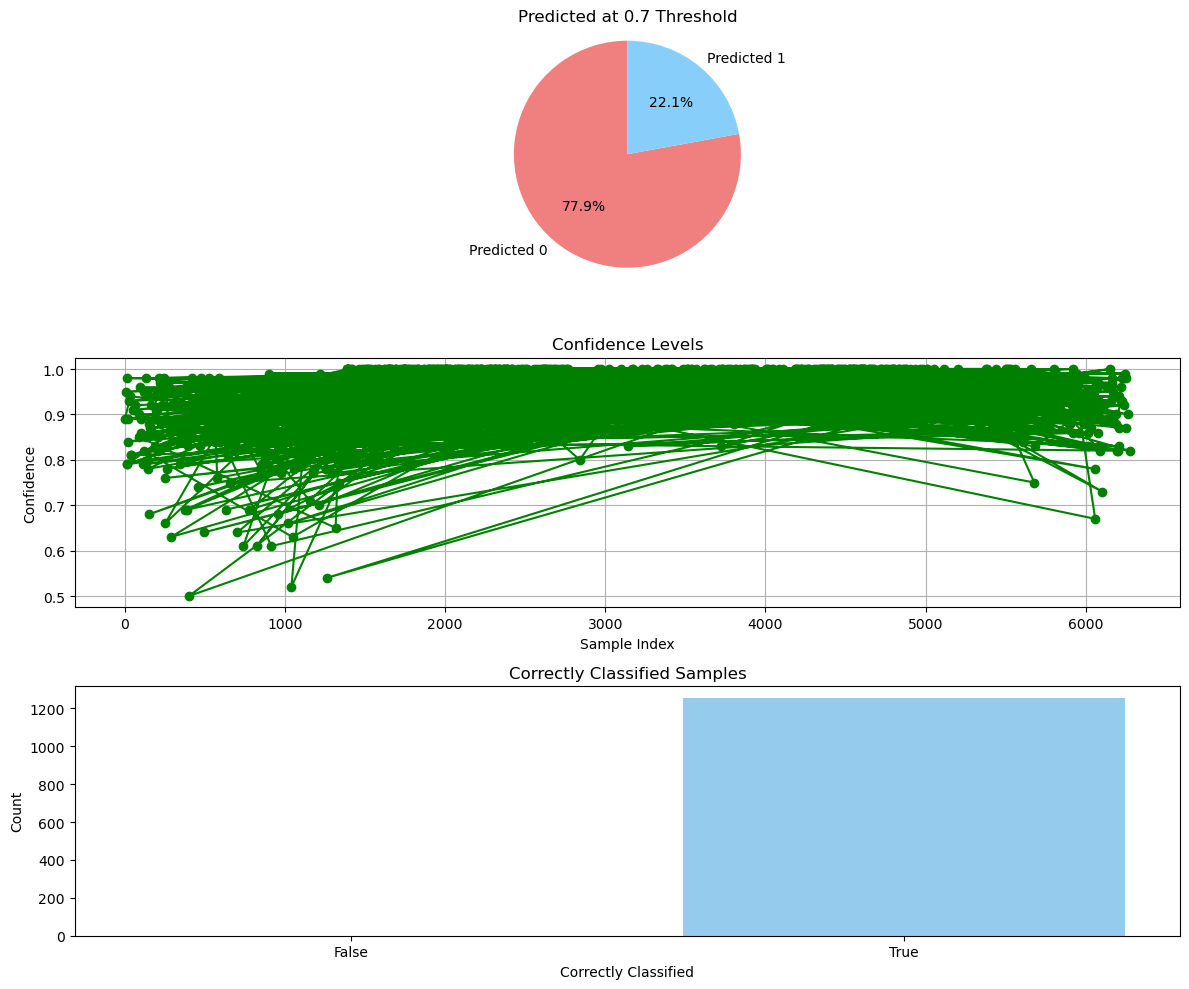

In [13]:

# Set up a 3x1 subplot grid
plt.figure(figsize=(12, 10))

# Pie chart for predicted_70
plt.subplot(3, 1, 1)
labels = ['Predicted 0', 'Predicted 1']
sizes = X_test['predicted_70'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Predicted at 0.7 Threshold')
plt.axis('equal')

# Line graph for confidence
plt.subplot(3, 1, 2)
plt.plot(X_test.index, X_test['confidence'], marker='o', linestyle='-', color='green')
plt.title('Confidence Levels')
plt.xlabel('Sample Index')
plt.ylabel('Confidence')
plt.grid(True)

# Horizontal bar chart for correctly_classified
plt.subplot(3, 1, 3)
sns.countplot(x='correctly_classified', data=X_test, palette=['lightcoral', 'lightskyblue'])
plt.title('Correctly Classified Samples')
plt.ylabel('Count')
plt.xlabel('Correctly Classified')

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

In [14]:

# AUC - ROC curve
def plot_roc(y_true, y_score, label, ax):
    # Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Plot the ROC curve
    ax.plot(fpr, tpr)
    
    # Plot the diagonal line representing random chance
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    
    # Set labels and title
    ax.set_ylabel('TPR')  # True Positive Rate (Sensitivity)
    ax.set_xlabel('FPR')  # False Positive Rate (1 - Specificity)
    ax.set_title(f"{label} AUC = {roc_auc_score(y_true, y_score):.2f}")


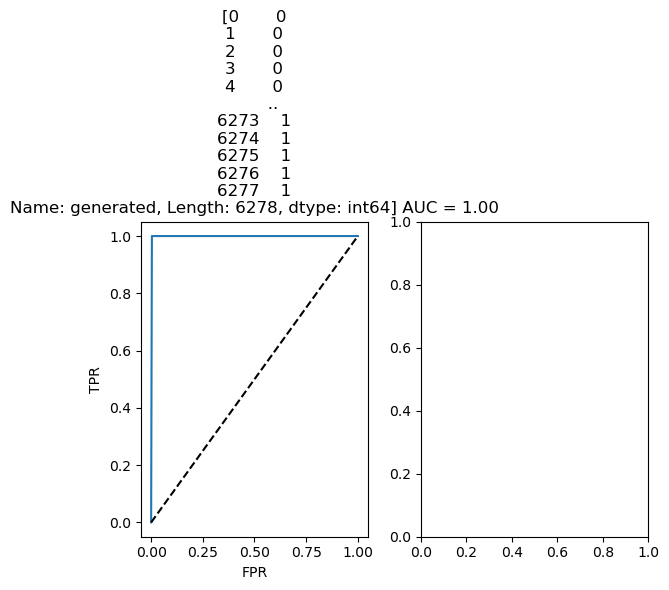

AUC-ROC Score: 0.9981818181818182


In [19]:

# auc-roc curve chart for training set
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

plot_roc(y_test, predictions, [y], ax=ax[0])

fig.tight_layout()
plt.show()


auc_roc = roc_auc_score(y_test, predictions)

print(f"AUC-ROC Score: {auc_roc}")

In [20]:

# Evaluate your model
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.2f} %')


Accuracy: 99.92 %


In [ ]:

# Load test essay
test_essays = pd.read_csv('C:\\Users\\jpark\\llm-mistral-7b-instruct-texts\\Mistral7B_CME_v1.csv')

# Preprocess the text data in test_essays
test_essays['cleaned_text'] = test_essays['text'].apply(preprocess_text)

# Vectorize the cleaned_text in test_essays using the same vectorizer fitted on X_train
test_essays_vec = vectorizer.transform(test_essays['cleaned_text'])

# Make predictions
test_predictions = model.predict(test_essays_vec)

# Add predictions to test_essays
test_essays['predicted'] = test_predictions


In [ ]:
print(test_essays)